In [1]:
%load_ext autoreload
%autoreload 2

import math
    
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-neurips"),
        {
             "font.size": 6, 
             "ytick.right": False,
             "xtick.major.size": 2.4,
             "xtick.major.pad": 1.5,
             "ytick.major.size": 2.4,
             "ytick.major.pad": 1.5,

        }
    ]
)

utils.import_plt_sty("robustness-macros.sty")

In [15]:
NAN = np.nan
data_blocks = [
    # outer dimension is victim visits (4, 16, 256, 4096)
    # rows are h0....h9,b18,vit
    # columns are r0...r9,attack-h9,cont-adv,ko-adv,attack-vit
    # value is victim win rate (row's win rate against column)
    # NAN = no data
    [
        [  1.0,    1.0,    0.0,    1.0,    1.0,    2.0,    2.0,    1.0,    0.0,    0.0,    1.0,    0.0,  100.0,    0.5],
        [  6.0,    0.0,    0.0,    4.0,    0.0,    1.0,    0.0,   15.0,    4.0,   16.0,    8.0,    9.0,    NAN,    NAN],
        [ 13.0,    3.0,    0.0,    2.0,    1.0,    1.0,    3.0,    3.0,    2.0,   10.0,    5.0,    0.0,    NAN,    NAN],
        [ 15.0,    9.0,    3.0,    1.0,    1.0,    3.0,    0.0,    4.0,    6.0,    9.0,    4.0,   17.0,    NAN,    NAN],
        [ 12.0,   18.0,   30.0,    9.0,    0.0,    5.0,    3.0,    1.0,    0.0,   14.0,    5.0,   16.0,    NAN,    NAN],
        [  1.0,   12.0,    3.0,    2.0,    9.0,    3.0,    3.0,    4.0,    1.0,   10.0,    6.0,   14.0,    NAN,    NAN],
        [  9.0,   12.0,    2.0,    1.0,    3.0,    3.0,    1.0,    3.0,    0.0,    9.0,    3.0,   12.0,    NAN,    NAN],
        [  4.0,    9.0,    0.0,    0.0,   12.0,    9.0,    5.0,    4.0,    2.0,    9.0,    6.0,   10.0,    NAN,    NAN],
        [  6.0,   20.0,    3.0,    1.0,   10.0,   10.0,   14.0,   13.0,    3.0,    6.0,    9.0,   14.0,    NAN,    NAN],
        [ 11.0,   14.0,    1.0,    1.0,    2.0,   10.0,   14.0,   25.0,   12.0,    6.5,    4.5,   16.0,  100.0,   14.0],
        [100.0,   96.0,   24.0,   70.0,   15.0,   76.0,   66.0,   37.0,   19.0,    0.0,   31.0,    0.5,    0.5,   93.5],
        [ 45.4,   24.0,    6.0,    5.0,    3.0,    4.0,    1.0,    6.0,    0.0,    1.0,   79.0,    5.0,  100.0,    1.5],
    ],
    [
        [  0.0,    2.0,    2.0,    6.0,    4.0,    7.0,    2.0,    3.0,    1.0,    1.0,    2.0,    1.0,  100.0,    1.5],
        [ 87.0,    1.5,    2.0,    2.0,    1.0,    3.0,    1.0,    6.0,    8.0,    4.0,   11.0,   12.0,    NAN,    NAN],
        [ 94.0,   66.0,    0.5,    5.0,   10.0,   21.0,   14.0,    6.0,    3.0,    3.0,    7.0,    9.0,    NAN,    NAN],
        [ 88.0,   85.0,   87.0,   12.5,    9.0,   27.0,   32.0,    4.0,   10.0,    0.0,    5.0,   25.0,    NAN,    NAN],
        [ 87.0,   90.0,   84.0,   82.0,    6.0,   75.0,   74.0,    6.0,   13.0,    4.0,    1.0,   41.0,    NAN,    NAN],
        [ 72.0,   91.0,   85.0,   92.0,   91.0,   49.2,   45.0,    2.0,    5.0,    3.0,    8.0,   24.0,    NAN,    NAN],
        [ 81.0,   83.0,   83.0,   92.0,   92.0,   90.0,   62.0,    1.0,    7.0,    3.0,    4.0,   38.0,    NAN,    NAN],
        [ 84.0,   84.0,   82.0,   94.0,   91.0,   86.0,   74.0,    6.0,   14.0,    1.0,   38.0,   40.0,    NAN,    NAN],
        [ 93.0,   89.0,   87.0,   83.0,   93.0,   92.0,   86.0,   84.0,   75.8,    2.0,    8.0,   37.0,    NAN,    NAN],
        [ 81.0,   91.0,   77.0,   94.0,   84.0,   92.0,   80.0,   95.0,   94.0,    0.2,    2.5,   40.0,  100.0,   56.0],
        [ 99.0,  100.0,   67.0,   98.0,   65.0,   96.0,   94.0,   55.0,   54.0,    4.0,   86.0,    1.0,    1.0,   93.0],
        [ 76.6,   49.0,   16.0,   27.0,   24.0,   19.0,   21.0,   22.0,    6.0,   11.0,  100.0,   37.0,  100.0,    1.0],
    ],
    [
        [  1.0,    2.0,    3.0,   23.0,    9.0,    9.0,   13.0,    4.0,    3.0,    5.0,   10.5,    7.0,  100.0,    3.0],
        [100.0,   14.0,    6.0,   12.0,    6.0,   26.0,   19.0,   31.0,   32.0,   29.0,   40.0,   65.0,    NAN,    NAN],
        [100.0,   96.0,    5.0,   31.0,   35.0,   69.0,   58.0,   44.0,   46.0,   27.0,   27.5,   86.0,    NAN,    NAN],
        [ 99.0,   99.0,   96.0,   33.0,   40.0,   80.0,   82.0,   35.0,   40.0,   17.0,   26.5,   97.0,    NAN,    NAN],
        [ 99.0,   97.0,   94.0,  100.0,   46.0,   98.0,   93.0,   45.0,   62.0,   11.0,   25.0,   99.0,    NAN,    NAN],
        [100.0,  100.0,   98.0,  100.0,  100.0,   97.0,   96.0,   38.0,   59.0,   19.0,   21.5,  100.0,    NAN,    NAN],
        [ 99.0,   97.0,   98.0,  100.0,   98.0,   99.0,   91.0,   39.0,   45.0,   10.0,   38.0,   99.0,    NAN,    NAN],
        [100.0,   98.0,   92.0,  100.0,   98.0,  100.0,   99.0,   53.0,   55.0,    9.0,   61.5,   98.0,    NAN,    NAN],
        [ 98.0,   97.0,   98.0,  100.0,  100.0,  100.0,   99.0,  100.0,  100.0,   17.0,   41.5,  100.0,    NAN,    NAN],
        [ 99.0,   98.0,   92.0,  100.0,   99.0,  100.0,   96.0,   98.0,   98.0,    5.8,    6.9,   95.0,  100.0,   97.0],
        [100.0,  100.0,   97.0,  100.0,  100.0,  100.0,  100.0,   98.0,   99.0,   34.0,   96.0,    7.6,    7.2,   99.5],
        [ 99.0,   87.0,   18.0,   88.0,   64.0,   80.0,   79.0,   99.0,   92.0,   80.0,  100.0,   97.0,  100.0,    4.0],
    ],
    [
        [  1.0,    5.0,    4.0,   24.0,    6.0,   14.0,   15.0,   13.0,    9.0,   10.0,   63.0,    NAN,    NAN,    NAN],
        [ 99.0,   31.0,   10.0,   34.0,   25.0,   55.0,   50.0,   59.0,   61.0,   64.0,   97.0,    NAN,    NAN,    NAN],
        [100.0,  100.0,   44.0,   71.0,   88.0,   95.0,   90.0,   78.0,   79.0,   72.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,  100.0,   67.0,   78.0,   95.0,   92.0,   77.0,   74.0,   51.0,   97.0,    NAN,    NAN,    NAN],
        [100.0,  100.0,   98.0,  100.0,   75.0,   99.0,   98.0,   86.0,   91.0,   62.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,  100.0,  100.0,  100.0,  100.0,  100.0,  100.0,   73.0,   84.0,   56.0,   99.0,    NAN,    NAN,    NAN],
        [ 99.0,  100.0,   97.0,  100.0,  100.0,  100.0,   98.0,   70.0,   76.0,   41.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,   98.0,  100.0,   99.0,  100.0,  100.0,   68.0,   70.0,   50.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,   99.0,  100.0,  100.0,  100.0,   99.0,  100.0,  100.0,   52.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,   94.0,  100.0,   99.0,  100.0,   99.0,  100.0,  100.0,   40.8,   96.0,    NAN,    NAN,    NAN],
        [  NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,   64.0,    NAN,   35.2,   85.2,    NAN],
        [  NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    7.6],
    ],
]

/tmp/ipykernel_601716/2514702971.py:64: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_601716/2514702971.py:64: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


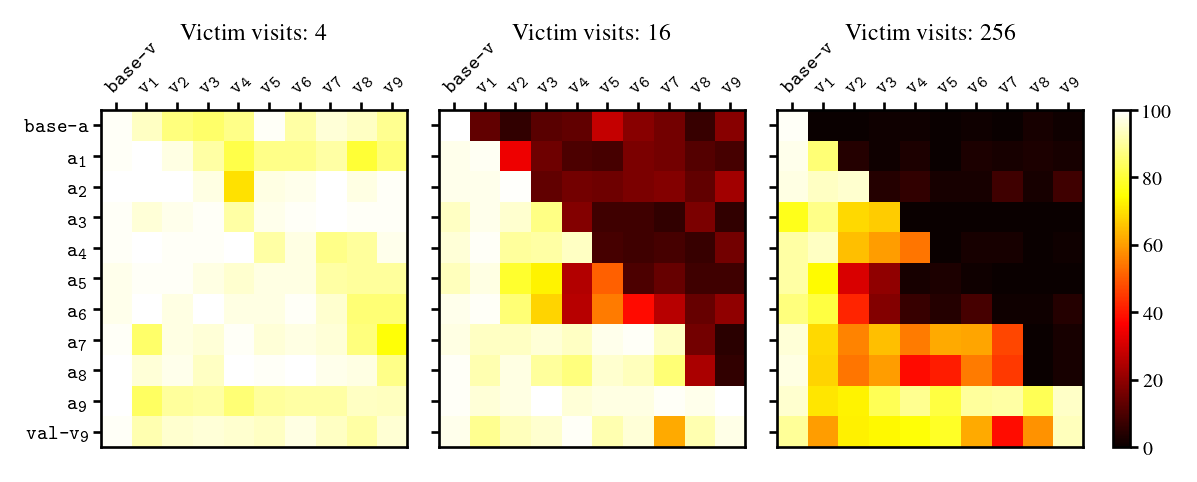

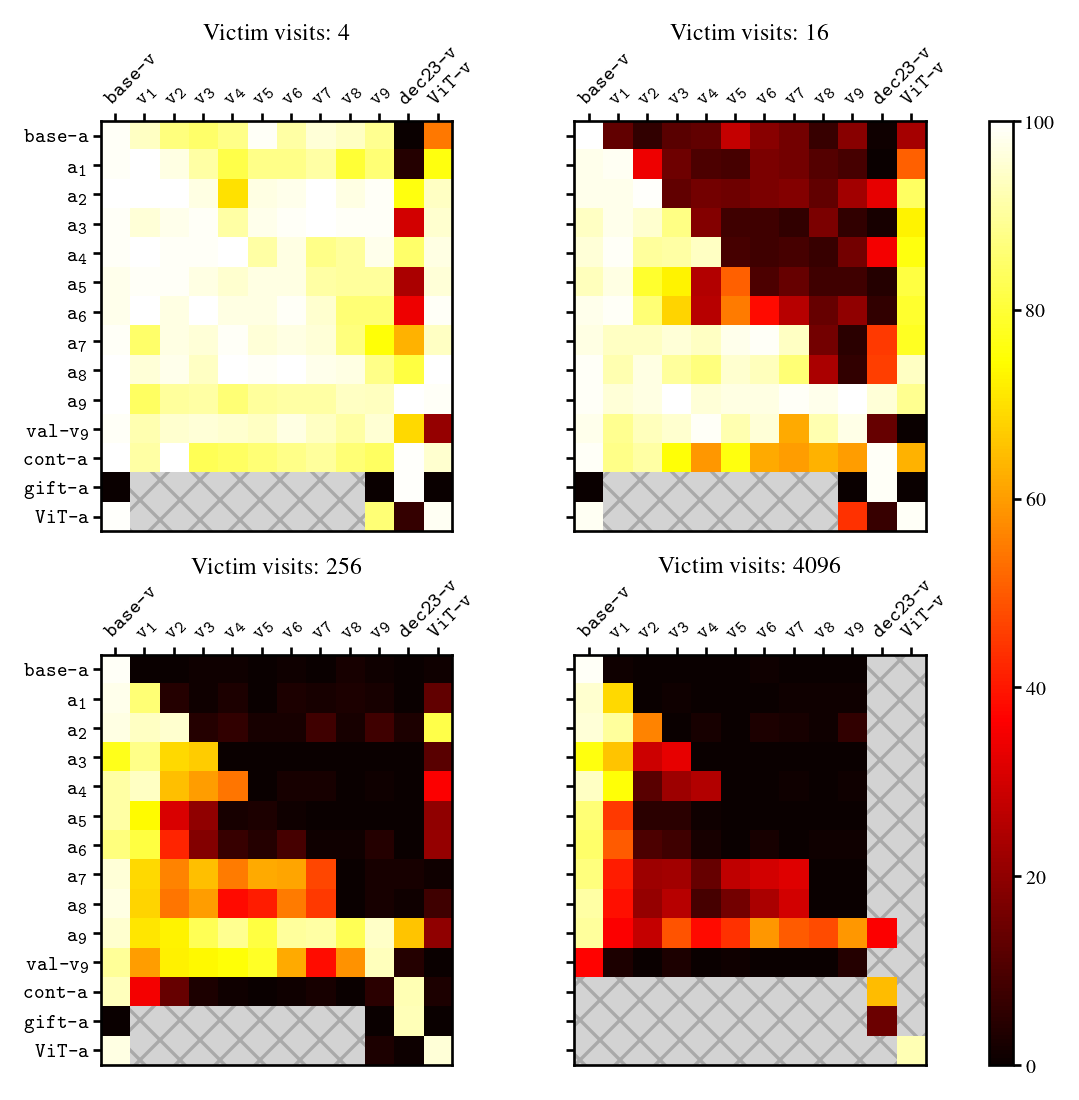

In [16]:
full_x_labels = [r"\cpfivezerofiveshort{}"] + [rf"\defenseiter{{{i}}}" for i in range(1, 10)] + [r"\dectwentythreeshort{}", r"\vitvictimshort{}"]
full_y_labels = [r"\origcyclicshort{}"] + [rf"\attackiter{{{i}}}" for i in range(1, 10)] + [r"\attackhnineshort{}", r"\contadvshort{}", r"\koadvshort{}", r"\vitadversaryshort{}"]
full_victim_visits = ["4", "16", "256", "4096"]

for label, x_labels_prefix, y_labels_prefix, victim_visits_prefix in [
    # Create one version of the plot with only iterated adv training for body of paper
    # and another version with all results.
   ("iteradvtrain", full_x_labels.index(r"\defenseiter{9}") + 1, full_y_labels.index(r"\attackhnineshort{}") + 1, len(full_victim_visits) - 1),
   ("full", len(full_x_labels), len(full_y_labels), len(full_victim_visits)) ,
]:
    x_labels = full_x_labels[:x_labels_prefix]
    y_labels = full_y_labels[:y_labels_prefix]
    victim_visits = full_victim_visits[:victim_visits_prefix]
    
    num_subplots = len(victim_visits)
    num_subplot_rows = 2 if num_subplots > 3 else 1 
    num_subplot_cols = int(math.ceil(num_subplots / num_subplot_rows))
    fig_height = 1.9 if num_subplot_rows == 1 else 4.5
    fig, axs = plt.subplots(
        num_subplot_rows, 
        num_subplot_cols, 
        figsize=(
            plt.rcParams["figure.figsize"][0], 
            fig_height,
        ),
        sharey=True,
    )
    axs = axs.ravel()
    
    vmin = 0
    vmax = 100
    color_map = matplotlib.colormaps.get_cmap("hot")
    normalizer = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    for ax, visits, block in zip(axs, victim_visits, data_blocks):
        data = np.array(block)
    
        # We usually report adversary win rates in our paper, so let's invert the
        # victim-win-rate data.
        # Also, let's put the adversaries as rows instead.
        data = 100 - data.T
        data = data[:len(y_labels), :len(x_labels)]
    
        ax.imshow(data, cmap=color_map, norm=normalizer)
    
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_yticks(np.arange(len(y_labels)))
        ax.set_xticklabels((rf"\texttt{{{name}}}" for name in x_labels), rotation=45, ha='left', rotation_mode='anchor')
        ax.set_yticklabels((rf"\texttt{{{name}}}" for name in y_labels))
        # Move x-axis labels to top so that r0 and h0 are together at the top-left
        # corner
        ax.xaxis.tick_top()

        ax.set_title(
            f"Victim visits: {visits}",
            # pad=0,
            # Reduce height further by shoving title towards x-axis labels
            y=1.15,
        )
    
        # Set the appearance of NaN cells
        ax.patch.set(hatch="xx", facecolor="lightgray", edgecolor="darkgray")

    fig.tight_layout()
    if num_subplot_rows > 1:
        # Increase vertical space between plots so it's clear which
        # subtitle appears on which subplot.
        fig.subplots_adjust(hspace=0.3)

    # We're creating this shared colorbar separate from the subplots so tight_layout
    # doesn't like it. We have to define the colorbar after tight_layout().
    color_bar_info = matplotlib.cm.ScalarMappable(cmap=color_map, norm=normalizer)
    fig.colorbar(
        color_bar_info,
        ax=axs,
        pad=0.025 if num_subplot_rows == 1 else 0.05,
        aspect=20 if num_subplot_rows == 1 else 40,
    ) 
    
    fig.savefig(f"win-rate-heatmap-{label}.pgf")